# Training Classifier Youtube

<li>https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html</li>

# Classifier 2D Binaire Youtube sur un Resnet
<p> Le code utilisé est celui de notre précédent classifier qui a été modifié </p>

## Loader

### Gestion de l'accès au drive / import des bibliothèques / Gestion de l'accès au GPU

In [2]:
########## Accès au drive ########
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
########## Positionnement dans le repertoire ########
%cd /content/drive/MyDrive/TSP/HTI/PFE
#%cd /content/drive/MyDrive/PFE
!ls

/content/drive/MyDrive/TSP/HTI/PFE
API				resnet180.0001.pth	    resnet180.1tiktok.pth
API-Database			resnet180.0001tiktok.pth    resnet180.1vidmizer.pth
Classifier_2D_c_tiktok.ipynb	resnet180.0001vidmizer.pth  test_tiktok
Classifier_2D_c_vidmizer.ipynb	resnet180.001.pth	    test_vidmizer
Classifier_2D_c_youtube.ipynb	resnet180.001tiktok.pth     test_youtube
Database_2D			resnet180.001vidmizer.pth   train_tiktok
Loader_2D_C.py			resnet180.01tiktok.pth	    train_vidmizer
__pycache__			resnet180.01vidmizer.pth    train_youtube


In [4]:
###### Librairies #######
import os
import pandas as pd
from torchvision.io import read_image
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
#########################

In [5]:
########## Gestion du GPU ###########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # see if gpu is available
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


### Fonctions de Customisation de Dataset et de Loader

In [6]:
########### Importation de la Classe Customisée ######
import sys
sys.path.append('Loader_2D_C.py')
print(sys.path)
from Loader_2D_C import CustomImageDataset

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', 'Loader_2D_C.py']


In [7]:
################# Modification selon la classe  du RESNET #########@

########## Path ##########
dataset_2D = './train_youtube'
dataset_test_2D = './test_youtube'
annotation_test = dataset_test_2D + '/label_test_youtube.txt'
annotation = dataset_2D + '/label_train_youtube.txt'

Calcul de la mean et de la vairiance du dataset

In [8]:
# Initialiser des variables pour accumuler les sommes et les sommes des carrés
sum_of_pixels = 0
sum_of_squares = 0
num_of_pixels = 0

# Parcourir le répertoire et charger chaque fichier .npy
for filename in os.listdir(dataset_2D):
    if filename.endswith('.npy'):
        filepath = os.path.join(dataset_2D, filename)
        data = np.load(filepath)  # Charger le fichier .npy

        # Accumuler les valeurs
        sum_of_pixels += np.sum(data)
        sum_of_squares += np.sum(data ** 2)
        num_of_pixels += data.size
        print(filepath)

# Calcul de la moyenne et de l'écart-type
mean = sum_of_pixels / num_of_pixels
std = np.sqrt((sum_of_squares / num_of_pixels) - (mean ** 2))
print()
print(f'Mean: {mean:.3f}, Std: {std:.3f}')

./train_youtube/tiktok_6_4.npy
./train_youtube/tiktok_6_2.npy
./train_youtube/tiktok_8_0.npy
./train_youtube/tiktok_0_1.npy
./train_youtube/tiktok_3_3.npy
./train_youtube/tiktok_3_0.npy
./train_youtube/tiktok_5_2.npy
./train_youtube/tiktok_2_3.npy
./train_youtube/tiktok_7_4.npy
./train_youtube/tiktok_1_4.npy
./train_youtube/tiktok_5_4.npy
./train_youtube/tiktok_1_5.npy
./train_youtube/tiktok_7_3.npy
./train_youtube/tiktok_1_2.npy
./train_youtube/tiktok_5_5.npy
./train_youtube/tiktok_5_3.npy
./train_youtube/tiktok_2_5.npy
./train_youtube/tiktok_4_7.npy
./train_youtube/tiktok_4_5.npy
./train_youtube/tiktok_4_3.npy
./train_youtube/tiktok_6_3.npy
./train_youtube/tiktok_6_5.npy
./train_youtube/tiktok_1_3.npy
./train_youtube/tiktok_2_4.npy
./train_youtube/tiktok_4_4.npy
./train_youtube/tiktok_3_2.npy
./train_youtube/tiktok_5_6.npy
./train_youtube/tiktok_0_0.npy
./train_youtube/tiktok_3_1.npy
./train_youtube/tiktok_2_2.npy
./train_youtube/tiktok_4_8.npy
./train_youtube/tiktok_7_2.npy
./train_

In [9]:
##### Image preprocessing #####
from torchvision import transforms
preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(576, antialias=True),  # image batch, resize smaller edge to 576
        transforms.CenterCrop(576),  # image batch, center crop to square 576x576
        transforms.Normalize(mean=[mean, mean, mean], std=[std, std, std])
])

In [10]:
array = np.zeros((5, 5))
print(array.shape)
array2 = np.stack((array,)*3, axis=-1)
array3 = np.stack((array)*3, axis=0)
array4 = np.stack((array)*3, axis=1)
print(array2.shape, array3.shape, array4.shape)
print(array2)


(5, 5)
(5, 5, 3) (5, 5) (5, 5)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


### Instance des Datasets et Loaders

In [11]:
############## Paramètre ################
batch_size = 64

############## Train Part ###############
train_set = CustomImageDataset(
    annotations_file = annotation,
    npy_dir = dataset_2D,
    transform=preprocess
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

############## Test Part ################

test_set = CustomImageDataset(
    annotations_file = annotation_test,
    npy_dir = dataset_test_2D,
    transform=preprocess
)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



In [12]:
sample_1 = train_set[0][0]
print(sample_1.shape)
print()
print(train_set[1])
print("max value : ", torch.max(sample_1), "min value : ", torch.min(sample_1))

torch.Size([3, 576, 576])

(tensor([[[0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044],
         [0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044],
         [0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044],
         ...,
         [0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044],
         [0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044],
         [0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044]],

        [[0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044],
         [0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044],
         [0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044],
         ...,
         [0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044],
         [0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044],
         [0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044]],

        [[0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044],
         [0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044],
         [0.0044, 0.0044, 0.00

### Try loader

torch.Size([3, 576, 576])


<function matplotlib.pyplot.show(close=None, block=None)>

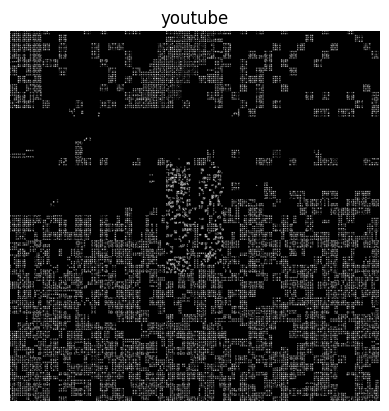

In [13]:
###### Fonction d'affichage ######
def denormalize(img_tensor):
        inverse_normalize = transforms.Normalize(
            mean=[-mean/std, -mean/std, -mean/std],
            std=[1/std, 1/std, 1/std]
        )
        return (inverse_normalize(img_tensor) * 255.).type(torch.uint8).permute(1, 2, 0).numpy()

labels_map = {
    0: "youtube" ,
    1: "autre",
}

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

img = images[0]
label = labels[0]
print(img.size())

plt.title(labels_map[int(label.numpy())])
plt.axis("off")
plt.imshow(denormalize(img))
plt.show


## Classifier

### Define the Convolutional Neural Network ( Utilisation de ResNet )

In [14]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm



In [15]:
net = torchvision.models.resnet18(weights=None)
num_ftrs = net.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
net.fc = nn.Linear(num_ftrs, 2)

In [16]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Define a Loss function and optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=.1)

In [18]:
num_class = 2

def quality_measurement(confusion_matrix):
    line_sum=torch.sum(confusion_matrix,dim=1)
    column_sum = torch.sum(confusion_matrix, dim=0)
    total_sum=torch.sum(confusion_matrix)
    Accuracy=torch.sum(torch.diag(confusion_matrix))/total_sum
    Precision=torch.diag(confusion_matrix)/line_sum
    Recall=torch.diag(confusion_matrix)/column_sum
    F1_score = 2 * (Precision * Recall)/(Precision+Recall)
    Pfa=(line_sum - torch.diag(confusion_matrix))/total_sum
    Pmd=(column_sum - torch.diag(confusion_matrix))/total_sum
    print("Accuracy : {}".format(Accuracy.item()))
    print("Precision 0 : {} - Precision 1 : {}".format(Precision[0],Precision[1]))
    print("Recall 0 : {} - Recall 1 : {}".format(Recall[0], Recall[1]))
    print("F1 score 0 : {} - F1 score 1 : {}".format(F1_score[0], F1_score[1]))
    print("Pfa 0 : {} - Pfa 1 : {}".format(Pfa[0], Pfa[1]))
    print("Pmd 0 : {} - Pmd 1 : {}".format(Pmd[0], Pmd[1]))
    return torch.nanmean(Accuracy),torch.nanmean(Precision),torch.nanmean(Recall),torch.nanmean(Recall),torch.nanmean(Pfa),torch.nanmean(Pmd)

def test_accuracy():
  net.eval()
  correct = 0
  total = 0
  confusion_matrix=torch.zeros((num_class,num_class),device=device)
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in test_loader:
          images, labels = data

          images = images.to(device)
          labels = labels.to(device)

          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          for i in range(len(labels)):
                label=int(labels[i])
                confusion_matrix[predicted[i],label]=confusion_matrix[predicted[i],label]+1
  net.train()
  print(quality_measurement(confusion_matrix))
  return  correct / total, confusion_matrix

In [19]:
list_lr = [0.1, 0.01, 0.001, 0.0001]
loss_saveds=[]
accuracy_saveds=[]
test_accuracy_saveds=[]



for lr_v in list_lr :
  net = torchvision.models.resnet18(weights=None)
  num_ftrs = net.fc.in_features
  net.fc = nn.Linear(num_ftrs, 2)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr_v)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=.1)
  net = net.to(device)
  loss_saved=[]
  accuracy_saved=[]
  test_accuracy_saved=[]


  for epoch in tqdm(range(50)):  # loop over the dataset multiple times

      running_loss = 0.0
      correct = 0
      total = 0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()


      loss_saved.append(running_loss/((i+1)*batch_size))
      accuracy_saved.append(correct / total)
      running_loss = 0.0
      scheduler.step()

      test_accuracy_val, matrice_confusion = test_accuracy()
      test_accuracy_saved.append(test_accuracy_val)

  print('Finished Training')
  print('Loss : ' , loss_saved)
  print('Accuracy : ' , accuracy_saved)
  print('Accuracy : ' , test_accuracy_saved)
  print( 'Matrice de confusion : ' , matrice_confusion)
  loss_saveds.append(loss_saved)
  accuracy_saveds.append(accuracy_saved)
  test_accuracy_saveds.append(test_accuracy_saved)
  PATH = f'./resnet18{lr_v}.pth'
  torch.save(net.state_dict(), PATH)



  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : nan
Recall 0 : 1.0 - Recall 1 : 0.0
F1 score 0 : 0.6666666865348816 - F1 score 1 : nan
Pfa 0 : 0.5 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.5


  2%|▏         | 1/50 [00:15<12:52, 15.77s/it]

(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


  4%|▍         | 2/50 [00:26<10:06, 12.64s/it]

Accuracy : 0.5
Precision 0 : nan - Precision 1 : 0.5
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.0 - Pfa 1 : 0.5
Pmd 0 : 0.5 - Pmd 1 : 0.0
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


  6%|▌         | 3/50 [00:34<08:20, 10.64s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5263158082962036 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.10000000149011612
F1 score 0 : 0.6896551847457886 - F1 score 1 : 0.1818181872367859
Pfa 0 : 0.44999998807907104 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.44999998807907104
(tensor(0.5500, device='cuda:0'), tensor(0.7632, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


  8%|▊         | 4/50 [00:44<08:04, 10.53s/it]

Accuracy : 0.5
Precision 0 : nan - Precision 1 : 0.5
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.0 - Pfa 1 : 0.5
Pmd 0 : 0.5 - Pmd 1 : 0.0
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 10%|█         | 5/50 [00:52<07:03,  9.41s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5555555820465088 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.20000000298023224
F1 score 0 : 0.7142857313156128 - F1 score 1 : 0.3333333134651184
Pfa 0 : 0.4000000059604645 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.4000000059604645
(tensor(0.6000, device='cuda:0'), tensor(0.7778, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 12%|█▏        | 6/50 [01:00<06:43,  9.16s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 14%|█▍        | 7/50 [01:10<06:41,  9.34s/it]

Accuracy : 0.6499999761581421
Precision 0 : 0.5882353186607361 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.30000001192092896
F1 score 0 : 0.7407407164573669 - F1 score 1 : 0.46153849363327026
Pfa 0 : 0.3499999940395355 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.3499999940395355
(tensor(0.6500, device='cuda:0'), tensor(0.7941, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.1750, device='cuda:0'), tensor(0.1750, device='cuda:0'))


 16%|█▌        | 8/50 [01:17<06:00,  8.59s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : nan
Recall 0 : 1.0 - Recall 1 : 0.0
F1 score 0 : 0.6666666865348816 - F1 score 1 : nan
Pfa 0 : 0.5 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.5
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 18%|█▊        | 9/50 [01:25<05:47,  8.48s/it]

Accuracy : 0.6499999761581421
Precision 0 : 0.5882353186607361 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.30000001192092896
F1 score 0 : 0.7407407164573669 - F1 score 1 : 0.46153849363327026
Pfa 0 : 0.3499999940395355 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.3499999940395355
(tensor(0.6500, device='cuda:0'), tensor(0.7941, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.1750, device='cuda:0'), tensor(0.1750, device='cuda:0'))


 20%|██        | 10/50 [01:33<05:23,  8.08s/it]

Accuracy : 0.6499999761581421
Precision 0 : 0.5882353186607361 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.30000001192092896
F1 score 0 : 0.7407407164573669 - F1 score 1 : 0.46153849363327026
Pfa 0 : 0.3499999940395355 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.3499999940395355
(tensor(0.6500, device='cuda:0'), tensor(0.7941, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.1750, device='cuda:0'), tensor(0.1750, device='cuda:0'))


 22%|██▏       | 11/50 [01:41<05:18,  8.16s/it]

Accuracy : 0.6499999761581421
Precision 0 : 0.5882353186607361 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.30000001192092896
F1 score 0 : 0.7407407164573669 - F1 score 1 : 0.46153849363327026
Pfa 0 : 0.3499999940395355 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.3499999940395355
(tensor(0.6500, device='cuda:0'), tensor(0.7941, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.1750, device='cuda:0'), tensor(0.1750, device='cuda:0'))


 24%|██▍       | 12/50 [01:48<05:00,  7.91s/it]

Accuracy : 0.6499999761581421
Precision 0 : 0.5882353186607361 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.30000001192092896
F1 score 0 : 0.7407407164573669 - F1 score 1 : 0.46153849363327026
Pfa 0 : 0.3499999940395355 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.3499999940395355
(tensor(0.6500, device='cuda:0'), tensor(0.7941, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.1750, device='cuda:0'), tensor(0.1750, device='cuda:0'))


 26%|██▌       | 13/50 [01:57<04:59,  8.09s/it]

Accuracy : 0.6499999761581421
Precision 0 : 0.5882353186607361 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.30000001192092896
F1 score 0 : 0.7407407164573669 - F1 score 1 : 0.46153849363327026
Pfa 0 : 0.3499999940395355 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.3499999940395355
(tensor(0.6500, device='cuda:0'), tensor(0.7941, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.1750, device='cuda:0'), tensor(0.1750, device='cuda:0'))


 28%|██▊       | 14/50 [02:04<04:44,  7.89s/it]

Accuracy : 0.6499999761581421
Precision 0 : 0.5882353186607361 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.30000001192092896
F1 score 0 : 0.7407407164573669 - F1 score 1 : 0.46153849363327026
Pfa 0 : 0.3499999940395355 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.3499999940395355
(tensor(0.6500, device='cuda:0'), tensor(0.7941, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.1750, device='cuda:0'), tensor(0.1750, device='cuda:0'))


 30%|███       | 15/50 [02:13<04:43,  8.11s/it]

Accuracy : 0.6499999761581421
Precision 0 : 0.5882353186607361 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.30000001192092896
F1 score 0 : 0.7407407164573669 - F1 score 1 : 0.46153849363327026
Pfa 0 : 0.3499999940395355 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.3499999940395355
(tensor(0.6500, device='cuda:0'), tensor(0.7941, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.1750, device='cuda:0'), tensor(0.1750, device='cuda:0'))


 32%|███▏      | 16/50 [02:20<04:26,  7.84s/it]

Accuracy : 0.699999988079071
Precision 0 : 0.625 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.7692307829856873 - F1 score 1 : 0.5714285969734192
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.30000001192092896
(tensor(0.7000, device='cuda:0'), tensor(0.8125, device='cuda:0'), tensor(0.7000, device='cuda:0'), tensor(0.7000, device='cuda:0'), tensor(0.1500, device='cuda:0'), tensor(0.1500, device='cuda:0'))


 34%|███▍      | 17/50 [02:29<04:25,  8.05s/it]

Accuracy : 0.699999988079071
Precision 0 : 0.625 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.7692307829856873 - F1 score 1 : 0.5714285969734192
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.30000001192092896
(tensor(0.7000, device='cuda:0'), tensor(0.8125, device='cuda:0'), tensor(0.7000, device='cuda:0'), tensor(0.7000, device='cuda:0'), tensor(0.1500, device='cuda:0'), tensor(0.1500, device='cuda:0'))


 36%|███▌      | 18/50 [02:36<04:08,  7.77s/it]

Accuracy : 0.6499999761581421
Precision 0 : 0.5882353186607361 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.30000001192092896
F1 score 0 : 0.7407407164573669 - F1 score 1 : 0.46153849363327026
Pfa 0 : 0.3499999940395355 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.3499999940395355
(tensor(0.6500, device='cuda:0'), tensor(0.7941, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.1750, device='cuda:0'), tensor(0.1750, device='cuda:0'))


 38%|███▊      | 19/50 [02:44<04:07,  7.99s/it]

Accuracy : 0.699999988079071
Precision 0 : 0.625 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.7692307829856873 - F1 score 1 : 0.5714285969734192
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.30000001192092896
(tensor(0.7000, device='cuda:0'), tensor(0.8125, device='cuda:0'), tensor(0.7000, device='cuda:0'), tensor(0.7000, device='cuda:0'), tensor(0.1500, device='cuda:0'), tensor(0.1500, device='cuda:0'))


 40%|████      | 20/50 [02:51<03:52,  7.74s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 42%|████▏     | 21/50 [03:00<03:51,  7.99s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 44%|████▍     | 22/50 [03:07<03:37,  7.77s/it]

Accuracy : 0.699999988079071
Precision 0 : 0.625 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.7692307829856873 - F1 score 1 : 0.5714285969734192
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.30000001192092896
(tensor(0.7000, device='cuda:0'), tensor(0.8125, device='cuda:0'), tensor(0.7000, device='cuda:0'), tensor(0.7000, device='cuda:0'), tensor(0.1500, device='cuda:0'), tensor(0.1500, device='cuda:0'))


 46%|████▌     | 23/50 [03:16<03:38,  8.11s/it]

Accuracy : 0.699999988079071
Precision 0 : 0.625 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.7692307829856873 - F1 score 1 : 0.5714285969734192
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.30000001192092896
(tensor(0.7000, device='cuda:0'), tensor(0.8125, device='cuda:0'), tensor(0.7000, device='cuda:0'), tensor(0.7000, device='cuda:0'), tensor(0.1500, device='cuda:0'), tensor(0.1500, device='cuda:0'))


 48%|████▊     | 24/50 [03:23<03:20,  7.71s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 50%|█████     | 25/50 [03:31<03:19,  7.98s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 52%|█████▏    | 26/50 [03:39<03:04,  7.71s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 54%|█████▍    | 27/50 [03:47<03:03,  7.99s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 56%|█████▌    | 28/50 [03:54<02:49,  7.72s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 58%|█████▊    | 29/50 [04:03<02:51,  8.16s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 60%|██████    | 30/50 [04:12<02:45,  8.27s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 62%|██████▏   | 31/50 [04:21<02:40,  8.45s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 64%|██████▍   | 32/50 [04:28<02:25,  8.10s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 66%|██████▌   | 33/50 [04:38<02:24,  8.49s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 68%|██████▊   | 34/50 [04:45<02:09,  8.12s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 70%|███████   | 35/50 [04:54<02:06,  8.41s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 72%|███████▏  | 36/50 [05:02<01:54,  8.21s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 74%|███████▍  | 37/50 [05:10<01:48,  8.33s/it]

Accuracy : 0.800000011920929
Precision 0 : 0.7142857313156128 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.8333333730697632 - F1 score 1 : 0.75
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.20000000298023224
(tensor(0.8000, device='cuda:0'), tensor(0.8571, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


 76%|███████▌  | 38/50 [05:18<01:37,  8.15s/it]

Accuracy : 0.75
Precision 0 : 0.6666666865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.5
F1 score 0 : 0.800000011920929 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.25 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.25
(tensor(0.7500, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.1250, device='cuda:0'), tensor(0.1250, device='cuda:0'))


 78%|███████▊  | 39/50 [05:26<01:29,  8.15s/it]

Accuracy : 0.800000011920929
Precision 0 : 0.7142857313156128 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.8333333730697632 - F1 score 1 : 0.75
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.20000000298023224
(tensor(0.8000, device='cuda:0'), tensor(0.8571, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


 80%|████████  | 40/50 [05:34<01:20,  8.01s/it]

Accuracy : 0.800000011920929
Precision 0 : 0.7142857313156128 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.8333333730697632 - F1 score 1 : 0.75
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.20000000298023224
(tensor(0.8000, device='cuda:0'), tensor(0.8571, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


 82%|████████▏ | 41/50 [05:42<01:11,  7.95s/it]

Accuracy : 0.800000011920929
Precision 0 : 0.7142857313156128 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.8333333730697632 - F1 score 1 : 0.75
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.20000000298023224
(tensor(0.8000, device='cuda:0'), tensor(0.8571, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


 84%|████████▍ | 42/50 [05:49<01:03,  7.90s/it]

Accuracy : 0.800000011920929
Precision 0 : 0.7142857313156128 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.8333333730697632 - F1 score 1 : 0.75
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.20000000298023224
(tensor(0.8000, device='cuda:0'), tensor(0.8571, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


 86%|████████▌ | 43/50 [05:57<00:55,  7.86s/it]

Accuracy : 0.800000011920929
Precision 0 : 0.7142857313156128 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.8333333730697632 - F1 score 1 : 0.75
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.20000000298023224
(tensor(0.8000, device='cuda:0'), tensor(0.8571, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


 88%|████████▊ | 44/50 [06:05<00:46,  7.82s/it]

Accuracy : 0.800000011920929
Precision 0 : 0.7142857313156128 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.8333333730697632 - F1 score 1 : 0.75
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.20000000298023224
(tensor(0.8000, device='cuda:0'), tensor(0.8571, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


 90%|█████████ | 45/50 [06:13<00:39,  7.83s/it]

Accuracy : 0.800000011920929
Precision 0 : 0.7142857313156128 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.8333333730697632 - F1 score 1 : 0.75
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.20000000298023224
(tensor(0.8000, device='cuda:0'), tensor(0.8571, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


 92%|█████████▏| 46/50 [06:21<00:31,  7.84s/it]

Accuracy : 0.800000011920929
Precision 0 : 0.7142857313156128 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.8333333730697632 - F1 score 1 : 0.75
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.20000000298023224
(tensor(0.8000, device='cuda:0'), tensor(0.8571, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


 94%|█████████▍| 47/50 [06:28<00:23,  7.75s/it]

Accuracy : 0.800000011920929
Precision 0 : 0.7142857313156128 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.8333333730697632 - F1 score 1 : 0.75
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.20000000298023224
(tensor(0.8000, device='cuda:0'), tensor(0.8571, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


 96%|█████████▌| 48/50 [06:36<00:15,  7.74s/it]

Accuracy : 0.800000011920929
Precision 0 : 0.7142857313156128 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.8333333730697632 - F1 score 1 : 0.75
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.20000000298023224
(tensor(0.8000, device='cuda:0'), tensor(0.8571, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


 98%|█████████▊| 49/50 [06:44<00:07,  7.74s/it]

Accuracy : 0.800000011920929
Precision 0 : 0.7142857313156128 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.8333333730697632 - F1 score 1 : 0.75
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.20000000298023224
(tensor(0.8000, device='cuda:0'), tensor(0.8571, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


100%|██████████| 50/50 [06:51<00:00,  8.23s/it]

Accuracy : 0.800000011920929
Precision 0 : 0.7142857313156128 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.8333333730697632 - F1 score 1 : 0.75
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.20000000298023224
(tensor(0.8000, device='cuda:0'), tensor(0.8571, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.8000, device='cuda:0'), tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))
Finished Training
Loss :  [0.06239415115366379, 0.04029214878877004, 0.01346750557422638, 0.014758003875613213, 0.01183693390339613, 0.009142531082034111, 0.00846074583629767, 0.008333312968413034, 0.007641312821457784, 0.0064703299043079214, 0.007681853448351224, 0.0062421040299038095, 0.006277038405338923, 0.005587338469922543, 0.005172043417890866, 0.006258670706301928, 0.004786623176187277, 0.005350467128058274, 0.005057530322422584, 0.004670655510077874, 0.004666765841344993, 0.003963113917658727, 0.004400647322957714, 0.0044


  2%|▏         | 1/50 [00:07<06:18,  7.72s/it]

Accuracy : 0.5
Precision 0 : nan - Precision 1 : 0.5
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.0 - Pfa 1 : 0.5
Pmd 0 : 0.5 - Pmd 1 : 0.0
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


  4%|▍         | 2/50 [00:16<06:49,  8.54s/it]

Accuracy : 0.6000000238418579
Precision 0 : 1.0 - Precision 1 : 0.5555555820465088
Recall 0 : 0.20000000298023224 - Recall 1 : 1.0
F1 score 0 : 0.3333333134651184 - F1 score 1 : 0.7142857313156128
Pfa 0 : 0.0 - Pfa 1 : 0.4000000059604645
Pmd 0 : 0.4000000059604645 - Pmd 1 : 0.0
(tensor(0.6000, device='cuda:0'), tensor(0.7778, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


  6%|▌         | 3/50 [00:25<06:50,  8.73s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.625 - Precision 1 : 0.5833333134651184
Recall 0 : 0.5 - Recall 1 : 0.699999988079071
F1 score 0 : 0.5555555820465088 - F1 score 1 : 0.6363636255264282
Pfa 0 : 0.15000000596046448 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.15000000596046448
(tensor(0.6000, device='cuda:0'), tensor(0.6042, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


  8%|▊         | 4/50 [00:34<06:33,  8.56s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.625 - Precision 1 : 0.5833333134651184
Recall 0 : 0.5 - Recall 1 : 0.699999988079071
F1 score 0 : 0.5555555820465088 - F1 score 1 : 0.6363636255264282
Pfa 0 : 0.15000000596046448 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.15000000596046448
(tensor(0.6000, device='cuda:0'), tensor(0.6042, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 10%|█         | 5/50 [00:41<06:04,  8.09s/it]

Accuracy : 0.6499999761581421
Precision 0 : 0.7142857313156128 - Precision 1 : 0.6153846383094788
Recall 0 : 0.5 - Recall 1 : 0.800000011920929
F1 score 0 : 0.5882353186607361 - F1 score 1 : 0.695652186870575
Pfa 0 : 0.10000000149011612 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.10000000149011612
(tensor(0.6500, device='cuda:0'), tensor(0.6648, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.1750, device='cuda:0'), tensor(0.1750, device='cuda:0'))


 12%|█▏        | 6/50 [00:49<05:57,  8.13s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 14%|█▍        | 7/50 [00:56<05:34,  7.78s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 16%|█▌        | 8/50 [01:04<05:30,  7.88s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 18%|█▊        | 9/50 [01:11<05:15,  7.68s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5625 - Precision 1 : 0.75
Recall 0 : 0.8999999761581421 - Recall 1 : 0.30000001192092896
F1 score 0 : 0.6923076510429382 - F1 score 1 : 0.4285714626312256
Pfa 0 : 0.3499999940395355 - Pfa 1 : 0.05000000074505806
Pmd 0 : 0.05000000074505806 - Pmd 1 : 0.3499999940395355
(tensor(0.6000, device='cuda:0'), tensor(0.6562, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 20%|██        | 10/50 [01:20<05:12,  7.81s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 22%|██▏       | 11/50 [01:27<04:55,  7.57s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 24%|██▍       | 12/50 [01:35<04:53,  7.71s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 26%|██▌       | 13/50 [01:42<04:42,  7.63s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 28%|██▊       | 14/50 [01:50<04:37,  7.70s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 30%|███       | 15/50 [01:57<04:26,  7.62s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 32%|███▏      | 16/50 [02:05<04:21,  7.69s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5384615659713745 - Precision 1 : 0.5714285969734192
Recall 0 : 0.699999988079071 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6086956858634949 - F1 score 1 : 0.47058823704719543
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.15000000596046448
Pmd 0 : 0.15000000596046448 - Pmd 1 : 0.30000001192092896
(tensor(0.5500, device='cuda:0'), tensor(0.5549, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 34%|███▍      | 17/50 [02:13<04:11,  7.62s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5384615659713745 - Precision 1 : 0.5714285969734192
Recall 0 : 0.699999988079071 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6086956858634949 - F1 score 1 : 0.47058823704719543
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.15000000596046448
Pmd 0 : 0.15000000596046448 - Pmd 1 : 0.30000001192092896
(tensor(0.5500, device='cuda:0'), tensor(0.5549, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 36%|███▌      | 18/50 [02:20<04:04,  7.64s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 38%|███▊      | 19/50 [02:28<03:57,  7.67s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5333333611488342 - Precision 1 : 0.6000000238418579
Recall 0 : 0.800000011920929 - Recall 1 : 0.30000001192092896
F1 score 0 : 0.64000004529953 - F1 score 1 : 0.4000000059604645
Pfa 0 : 0.3499999940395355 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.3499999940395355
(tensor(0.5500, device='cuda:0'), tensor(0.5667, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 40%|████      | 20/50 [02:36<03:51,  7.73s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 42%|████▏     | 21/50 [02:44<03:42,  7.68s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 44%|████▍     | 22/50 [02:51<03:35,  7.70s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 46%|████▌     | 23/50 [02:59<03:27,  7.68s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 48%|████▊     | 24/50 [03:07<03:19,  7.66s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 50%|█████     | 25/50 [03:14<03:10,  7.60s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5384615659713745 - Precision 1 : 0.5714285969734192
Recall 0 : 0.699999988079071 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6086956858634949 - F1 score 1 : 0.47058823704719543
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.15000000596046448
Pmd 0 : 0.15000000596046448 - Pmd 1 : 0.30000001192092896
(tensor(0.5500, device='cuda:0'), tensor(0.5549, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 52%|█████▏    | 26/50 [03:24<03:18,  8.28s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5384615659713745 - Precision 1 : 0.5714285969734192
Recall 0 : 0.699999988079071 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6086956858634949 - F1 score 1 : 0.47058823704719543
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.15000000596046448
Pmd 0 : 0.15000000596046448 - Pmd 1 : 0.30000001192092896
(tensor(0.5500, device='cuda:0'), tensor(0.5549, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 54%|█████▍    | 27/50 [03:32<03:06,  8.10s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5384615659713745 - Precision 1 : 0.5714285969734192
Recall 0 : 0.699999988079071 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6086956858634949 - F1 score 1 : 0.47058823704719543
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.15000000596046448
Pmd 0 : 0.15000000596046448 - Pmd 1 : 0.30000001192092896
(tensor(0.5500, device='cuda:0'), tensor(0.5549, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 56%|█████▌    | 28/50 [03:39<02:55,  7.96s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5384615659713745 - Precision 1 : 0.5714285969734192
Recall 0 : 0.699999988079071 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6086956858634949 - F1 score 1 : 0.47058823704719543
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.15000000596046448
Pmd 0 : 0.15000000596046448 - Pmd 1 : 0.30000001192092896
(tensor(0.5500, device='cuda:0'), tensor(0.5549, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 58%|█████▊    | 29/50 [03:47<02:45,  7.90s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 60%|██████    | 30/50 [03:54<02:35,  7.77s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 62%|██████▏   | 31/50 [04:02<02:28,  7.79s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 64%|██████▍   | 32/50 [04:10<02:19,  7.75s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 66%|██████▌   | 33/50 [04:18<02:11,  7.72s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 68%|██████▊   | 34/50 [04:25<02:03,  7.71s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 70%|███████   | 35/50 [04:33<01:55,  7.68s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 72%|███████▏  | 36/50 [04:41<01:47,  7.70s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 74%|███████▍  | 37/50 [04:48<01:39,  7.69s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5384615659713745 - Precision 1 : 0.5714285969734192
Recall 0 : 0.699999988079071 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6086956858634949 - F1 score 1 : 0.47058823704719543
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.15000000596046448
Pmd 0 : 0.15000000596046448 - Pmd 1 : 0.30000001192092896
(tensor(0.5500, device='cuda:0'), tensor(0.5549, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 76%|███████▌  | 38/50 [04:56<01:31,  7.66s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5384615659713745 - Precision 1 : 0.5714285969734192
Recall 0 : 0.699999988079071 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6086956858634949 - F1 score 1 : 0.47058823704719543
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.15000000596046448
Pmd 0 : 0.15000000596046448 - Pmd 1 : 0.30000001192092896
(tensor(0.5500, device='cuda:0'), tensor(0.5549, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 78%|███████▊  | 39/50 [05:04<01:24,  7.68s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5384615659713745 - Precision 1 : 0.5714285969734192
Recall 0 : 0.699999988079071 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6086956858634949 - F1 score 1 : 0.47058823704719543
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.15000000596046448
Pmd 0 : 0.15000000596046448 - Pmd 1 : 0.30000001192092896
(tensor(0.5500, device='cuda:0'), tensor(0.5549, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 80%|████████  | 40/50 [05:11<01:17,  7.73s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 82%|████████▏ | 41/50 [05:19<01:08,  7.66s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 84%|████████▍ | 42/50 [05:27<01:01,  7.65s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 86%|████████▌ | 43/50 [05:34<00:53,  7.68s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 88%|████████▊ | 44/50 [05:42<00:46,  7.74s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 90%|█████████ | 45/50 [05:50<00:38,  7.71s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 92%|█████████▏| 46/50 [05:58<00:30,  7.71s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 94%|█████████▍| 47/50 [06:05<00:23,  7.68s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 96%|█████████▌| 48/50 [06:13<00:15,  7.74s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5333333611488342 - Precision 1 : 0.6000000238418579
Recall 0 : 0.800000011920929 - Recall 1 : 0.30000001192092896
F1 score 0 : 0.64000004529953 - F1 score 1 : 0.4000000059604645
Pfa 0 : 0.3499999940395355 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.3499999940395355
(tensor(0.5500, device='cuda:0'), tensor(0.5667, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 98%|█████████▊| 49/50 [06:21<00:07,  7.87s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


100%|██████████| 50/50 [06:30<00:00,  7.81s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.5714285969734192 - Precision 1 : 0.6666666865348816
Recall 0 : 0.800000011920929 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.6666666865348816 - F1 score 1 : 0.5
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.10000000149011612
Pmd 0 : 0.10000000149011612 - Pmd 1 : 0.30000001192092896
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))
Finished Training
Loss :  [0.010987110125521818, 0.010732694218556086, 0.010291876581807932, 0.009972531658907732, 0.009925184771418571, 0.009674129697183767, 0.009590319047371546, 0.009685599555571875, 0.009230193682014942, 0.009435435446600119, 0.009087204312284788, 0.009252196488281092, 0.00935424460719029, 0.009111525801320871, 0.008873333844045797, 0.009222736582159996, 0.009168311953544617, 0.009282094736893972, 0.00916159339249134, 0.009175868394474188, 0.00916530


  2%|▏         | 1/50 [00:07<05:59,  7.33s/it]

Accuracy : 0.6499999761581421
Precision 0 : 0.800000011920929 - Precision 1 : 0.6000000238418579
Recall 0 : 0.4000000059604645 - Recall 1 : 0.8999999761581421
F1 score 0 : 0.5333333611488342 - F1 score 1 : 0.7200000286102295
Pfa 0 : 0.05000000074505806 - Pfa 1 : 0.30000001192092896
Pmd 0 : 0.30000001192092896 - Pmd 1 : 0.05000000074505806
(tensor(0.6500, device='cuda:0'), tensor(0.7000, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.6500, device='cuda:0'), tensor(0.1750, device='cuda:0'), tensor(0.1750, device='cuda:0'))


  4%|▍         | 2/50 [00:16<06:39,  8.33s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6666666865348816 - Precision 1 : 0.5714285969734192
Recall 0 : 0.4000000059604645 - Recall 1 : 0.800000011920929
F1 score 0 : 0.5 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.10000000149011612 - Pfa 1 : 0.30000001192092896
Pmd 0 : 0.30000001192092896 - Pmd 1 : 0.10000000149011612
(tensor(0.6000, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


  6%|▌         | 3/50 [00:23<06:03,  7.73s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.625 - Precision 1 : 0.5833333134651184
Recall 0 : 0.5 - Recall 1 : 0.699999988079071
F1 score 0 : 0.5555555820465088 - F1 score 1 : 0.6363636255264282
Pfa 0 : 0.15000000596046448 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.15000000596046448
(tensor(0.6000, device='cuda:0'), tensor(0.6042, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


  8%|▊         | 4/50 [00:32<06:13,  8.11s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.625 - Precision 1 : 0.5833333134651184
Recall 0 : 0.5 - Recall 1 : 0.699999988079071
F1 score 0 : 0.5555555820465088 - F1 score 1 : 0.6363636255264282
Pfa 0 : 0.15000000596046448 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.15000000596046448
(tensor(0.6000, device='cuda:0'), tensor(0.6042, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 10%|█         | 5/50 [00:39<05:50,  7.80s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.625 - Precision 1 : 0.5833333134651184
Recall 0 : 0.5 - Recall 1 : 0.699999988079071
F1 score 0 : 0.5555555820465088 - F1 score 1 : 0.6363636255264282
Pfa 0 : 0.15000000596046448 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.15000000596046448
(tensor(0.6000, device='cuda:0'), tensor(0.6042, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 12%|█▏        | 6/50 [00:48<06:04,  8.28s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5555555820465088 - Precision 1 : 0.5454545617103577
Recall 0 : 0.5 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.5263158082962036 - F1 score 1 : 0.5714285373687744
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.20000000298023224
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 14%|█▍        | 7/50 [00:55<05:41,  7.95s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5555555820465088 - Precision 1 : 0.5454545617103577
Recall 0 : 0.5 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.5263158082962036 - F1 score 1 : 0.5714285373687744
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.20000000298023224
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 16%|█▌        | 8/50 [01:05<05:53,  8.41s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 18%|█▊        | 9/50 [01:12<05:36,  8.21s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5555555820465088 - Precision 1 : 0.5454545617103577
Recall 0 : 0.5 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.5263158082962036 - F1 score 1 : 0.5714285373687744
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.20000000298023224
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 20%|██        | 10/50 [01:21<05:37,  8.44s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.625 - Precision 1 : 0.5833333134651184
Recall 0 : 0.5 - Recall 1 : 0.699999988079071
F1 score 0 : 0.5555555820465088 - F1 score 1 : 0.6363636255264282
Pfa 0 : 0.15000000596046448 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.15000000596046448
(tensor(0.6000, device='cuda:0'), tensor(0.6042, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 22%|██▏       | 11/50 [01:29<05:20,  8.22s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 24%|██▍       | 12/50 [01:38<05:15,  8.30s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 26%|██▌       | 13/50 [01:46<05:02,  8.18s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 28%|██▊       | 14/50 [01:53<04:51,  8.09s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 30%|███       | 15/50 [02:01<04:39,  7.98s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 32%|███▏      | 16/50 [02:09<04:28,  7.91s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 34%|███▍      | 17/50 [02:17<04:20,  7.89s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 36%|███▌      | 18/50 [02:24<04:11,  7.85s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 38%|███▊      | 19/50 [02:33<04:05,  7.93s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 40%|████      | 20/50 [02:40<03:54,  7.82s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 42%|████▏     | 21/50 [02:50<04:01,  8.34s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 44%|████▍     | 22/50 [02:59<03:59,  8.54s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 46%|████▌     | 23/50 [03:08<03:57,  8.79s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 48%|████▊     | 24/50 [03:16<03:39,  8.45s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 50%|█████     | 25/50 [03:26<03:43,  8.92s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 52%|█████▏    | 26/50 [03:34<03:28,  8.69s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 54%|█████▍    | 27/50 [03:43<03:22,  8.79s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 56%|█████▌    | 28/50 [03:51<03:08,  8.59s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 58%|█████▊    | 29/50 [04:00<03:00,  8.59s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 60%|██████    | 30/50 [04:08<02:47,  8.37s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 62%|██████▏   | 31/50 [04:15<02:34,  8.14s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 64%|██████▍   | 32/50 [04:23<02:25,  8.09s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 66%|██████▌   | 33/50 [04:30<02:13,  7.86s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 68%|██████▊   | 34/50 [04:38<02:04,  7.78s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 70%|███████   | 35/50 [04:46<01:56,  7.76s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 72%|███████▏  | 36/50 [04:54<01:49,  7.82s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 74%|███████▍  | 37/50 [05:01<01:39,  7.69s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 76%|███████▌  | 38/50 [05:09<01:32,  7.70s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 78%|███████▊  | 39/50 [05:17<01:25,  7.73s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 80%|████████  | 40/50 [05:25<01:17,  7.79s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 82%|████████▏ | 41/50 [05:32<01:09,  7.77s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 84%|████████▍ | 42/50 [05:40<01:02,  7.79s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 86%|████████▌ | 43/50 [05:48<00:55,  7.91s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 88%|████████▊ | 44/50 [05:57<00:49,  8.25s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 90%|█████████ | 45/50 [06:05<00:39,  7.95s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 92%|█████████▏| 46/50 [06:13<00:32,  8.12s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 94%|█████████▍| 47/50 [06:20<00:23,  7.83s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.6000000238418579 - Recall 1 : 0.4000000059604645
F1 score 0 : 0.5454545617103577 - F1 score 1 : 0.444444477558136
Pfa 0 : 0.30000001192092896 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.30000001192092896
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


 96%|█████████▌| 48/50 [06:29<00:16,  8.01s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 98%|█████████▊| 49/50 [06:36<00:07,  7.79s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


100%|██████████| 50/50 [06:44<00:00,  8.09s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5454545617103577 - Precision 1 : 0.5555555820465088
Recall 0 : 0.6000000238418579 - Recall 1 : 0.5
F1 score 0 : 0.5714285373687744 - F1 score 1 : 0.5263158082962036
Pfa 0 : 0.25 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.25
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))
Finished Training
Loss :  [0.010475905301670233, 0.010358277397851149, 0.010580592788755894, 0.010428854574759802, 0.010920216950277487, 0.010505877124766508, 0.010337797614435354, 0.01052414874235789, 0.010240139439702034, 0.010175385201970736, 0.010369574961562952, 0.010308592580258846, 0.010354405889908472, 0.01050553967555364, 0.010640118271112442, 0.010245926988621553, 0.01017867960035801, 0.010192855882147947, 0.010428806145985922, 0.010179617752631506, 0.010653946548700333, 0.01029426977038383


  2%|▏         | 1/50 [00:07<06:30,  7.96s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.6666666865348816 - Precision 1 : 0.529411792755127
Recall 0 : 0.20000000298023224 - Recall 1 : 0.8999999761581421
F1 score 0 : 0.3076923191547394 - F1 score 1 : 0.6666666865348816
Pfa 0 : 0.05000000074505806 - Pfa 1 : 0.4000000059604645
Pmd 0 : 0.4000000059604645 - Pmd 1 : 0.05000000074505806
(tensor(0.5500, device='cuda:0'), tensor(0.5980, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


  4%|▍         | 2/50 [00:16<06:50,  8.55s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.20000000298023224 - Recall 1 : 0.800000011920929
F1 score 0 : 0.2857142984867096 - F1 score 1 : 0.6153846383094788
Pfa 0 : 0.10000000149011612 - Pfa 1 : 0.4000000059604645
Pmd 0 : 0.4000000059604645 - Pmd 1 : 0.10000000149011612
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


  6%|▌         | 3/50 [00:24<06:23,  8.16s/it]

Accuracy : 0.5
Precision 0 : 0.5 - Precision 1 : 0.5
Recall 0 : 0.20000000298023224 - Recall 1 : 0.800000011920929
F1 score 0 : 0.2857142984867096 - F1 score 1 : 0.6153846383094788
Pfa 0 : 0.10000000149011612 - Pfa 1 : 0.4000000059604645
Pmd 0 : 0.4000000059604645 - Pmd 1 : 0.10000000149011612
(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2500, device='cuda:0'), tensor(0.2500, device='cuda:0'))


  8%|▊         | 4/50 [00:32<06:17,  8.21s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5714285969734192 - Precision 1 : 0.5384615659713745
Recall 0 : 0.4000000059604645 - Recall 1 : 0.699999988079071
F1 score 0 : 0.47058823704719543 - F1 score 1 : 0.6086956858634949
Pfa 0 : 0.15000000596046448 - Pfa 1 : 0.30000001192092896
Pmd 0 : 0.30000001192092896 - Pmd 1 : 0.15000000596046448
(tensor(0.5500, device='cuda:0'), tensor(0.5549, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 10%|█         | 5/50 [00:40<06:01,  8.03s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.625 - Precision 1 : 0.5833333134651184
Recall 0 : 0.5 - Recall 1 : 0.699999988079071
F1 score 0 : 0.5555555820465088 - F1 score 1 : 0.6363636255264282
Pfa 0 : 0.15000000596046448 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.15000000596046448
(tensor(0.6000, device='cuda:0'), tensor(0.6042, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 12%|█▏        | 6/50 [00:48<05:51,  7.98s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.625 - Precision 1 : 0.5833333134651184
Recall 0 : 0.5 - Recall 1 : 0.699999988079071
F1 score 0 : 0.5555555820465088 - F1 score 1 : 0.6363636255264282
Pfa 0 : 0.15000000596046448 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.15000000596046448
(tensor(0.6000, device='cuda:0'), tensor(0.6042, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 14%|█▍        | 7/50 [00:56<05:40,  7.91s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.625 - Precision 1 : 0.5833333134651184
Recall 0 : 0.5 - Recall 1 : 0.699999988079071
F1 score 0 : 0.5555555820465088 - F1 score 1 : 0.6363636255264282
Pfa 0 : 0.15000000596046448 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.15000000596046448
(tensor(0.6000, device='cuda:0'), tensor(0.6042, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 16%|█▌        | 8/50 [01:04<05:31,  7.88s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.625 - Precision 1 : 0.5833333134651184
Recall 0 : 0.5 - Recall 1 : 0.699999988079071
F1 score 0 : 0.5555555820465088 - F1 score 1 : 0.6363636255264282
Pfa 0 : 0.15000000596046448 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.15000000596046448
(tensor(0.6000, device='cuda:0'), tensor(0.6042, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 18%|█▊        | 9/50 [01:11<05:22,  7.85s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5555555820465088 - Precision 1 : 0.5454545617103577
Recall 0 : 0.5 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.5263158082962036 - F1 score 1 : 0.5714285373687744
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.20000000298023224
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 20%|██        | 10/50 [01:19<05:07,  7.69s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5555555820465088 - Precision 1 : 0.5454545617103577
Recall 0 : 0.5 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.5263158082962036 - F1 score 1 : 0.5714285373687744
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.20000000298023224
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 22%|██▏       | 11/50 [01:27<05:02,  7.76s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5555555820465088 - Precision 1 : 0.5454545617103577
Recall 0 : 0.5 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.5263158082962036 - F1 score 1 : 0.5714285373687744
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.20000000298023224
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 24%|██▍       | 12/50 [01:34<04:53,  7.73s/it]

Accuracy : 0.550000011920929
Precision 0 : 0.5555555820465088 - Precision 1 : 0.5454545617103577
Recall 0 : 0.5 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.5263158082962036 - F1 score 1 : 0.5714285373687744
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.25
Pmd 0 : 0.25 - Pmd 1 : 0.20000000298023224
(tensor(0.5500, device='cuda:0'), tensor(0.5505, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.5500, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(0.2250, device='cuda:0'))


 26%|██▌       | 13/50 [01:42<04:46,  7.74s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 28%|██▊       | 14/50 [01:50<04:38,  7.74s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 30%|███       | 15/50 [01:58<04:32,  7.80s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 32%|███▏      | 16/50 [02:08<04:48,  8.49s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 34%|███▍      | 17/50 [02:15<04:30,  8.18s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 36%|███▌      | 18/50 [02:23<04:21,  8.16s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 38%|███▊      | 19/50 [02:31<04:09,  8.06s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 40%|████      | 20/50 [02:39<04:01,  8.04s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 42%|████▏     | 21/50 [02:47<03:52,  8.02s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 44%|████▍     | 22/50 [02:55<03:42,  7.93s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 46%|████▌     | 23/50 [03:03<03:33,  7.92s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 48%|████▊     | 24/50 [03:11<03:24,  7.86s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 50%|█████     | 25/50 [03:18<03:16,  7.86s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 52%|█████▏    | 26/50 [03:26<03:07,  7.82s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 54%|█████▍    | 27/50 [03:34<03:00,  7.86s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 56%|█████▌    | 28/50 [03:42<02:51,  7.77s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 58%|█████▊    | 29/50 [03:50<02:45,  7.87s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 60%|██████    | 30/50 [03:57<02:35,  7.79s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 62%|██████▏   | 31/50 [04:05<02:29,  7.84s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 64%|██████▍   | 32/50 [04:13<02:18,  7.71s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 66%|██████▌   | 33/50 [04:21<02:12,  7.79s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 68%|██████▊   | 34/50 [04:28<02:04,  7.77s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 70%|███████   | 35/50 [04:36<01:57,  7.82s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 72%|███████▏  | 36/50 [04:44<01:49,  7.80s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 74%|███████▍  | 37/50 [04:52<01:42,  7.91s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 76%|███████▌  | 38/50 [05:02<01:41,  8.46s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 78%|███████▊  | 39/50 [05:11<01:33,  8.52s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 80%|████████  | 40/50 [05:18<01:21,  8.13s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 82%|████████▏ | 41/50 [05:27<01:14,  8.33s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 84%|████████▍ | 42/50 [05:34<01:04,  8.02s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 86%|████████▌ | 43/50 [05:43<00:58,  8.31s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 88%|████████▊ | 44/50 [05:50<00:48,  8.04s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 90%|█████████ | 45/50 [06:00<00:41,  8.40s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 92%|█████████▏| 46/50 [06:07<00:32,  8.12s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 94%|█████████▍| 47/50 [06:16<00:25,  8.43s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 96%|█████████▌| 48/50 [06:24<00:16,  8.12s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


 98%|█████████▊| 49/50 [06:33<00:08,  8.55s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))


100%|██████████| 50/50 [06:41<00:00,  8.02s/it]

Accuracy : 0.6000000238418579
Precision 0 : 0.6000000238418579 - Precision 1 : 0.6000000238418579
Recall 0 : 0.6000000238418579 - Recall 1 : 0.6000000238418579
F1 score 0 : 0.6000000238418579 - F1 score 1 : 0.6000000238418579
Pfa 0 : 0.20000000298023224 - Pfa 1 : 0.20000000298023224
Pmd 0 : 0.20000000298023224 - Pmd 1 : 0.20000000298023224
(tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.2000, device='cuda:0'), tensor(0.2000, device='cuda:0'))
Finished Training
Loss :  [0.010402888680497805, 0.010297510772943497, 0.011130056343972683, 0.010930294791857401, 0.010679886365930239, 0.010561641616125902, 0.010355836090942224, 0.010360158048570156, 0.010374394245445728, 0.010844096541404724, 0.010407212500770887, 0.011044390189150969, 0.010356109589338303, 0.011016543954610825, 0.010703633228937784, 0.010317840613424778, 0.010962046372393766, 0.010408985118071238, 0.010366576723754406, 0.010281655937

### Print de la loss en fonction des epochs

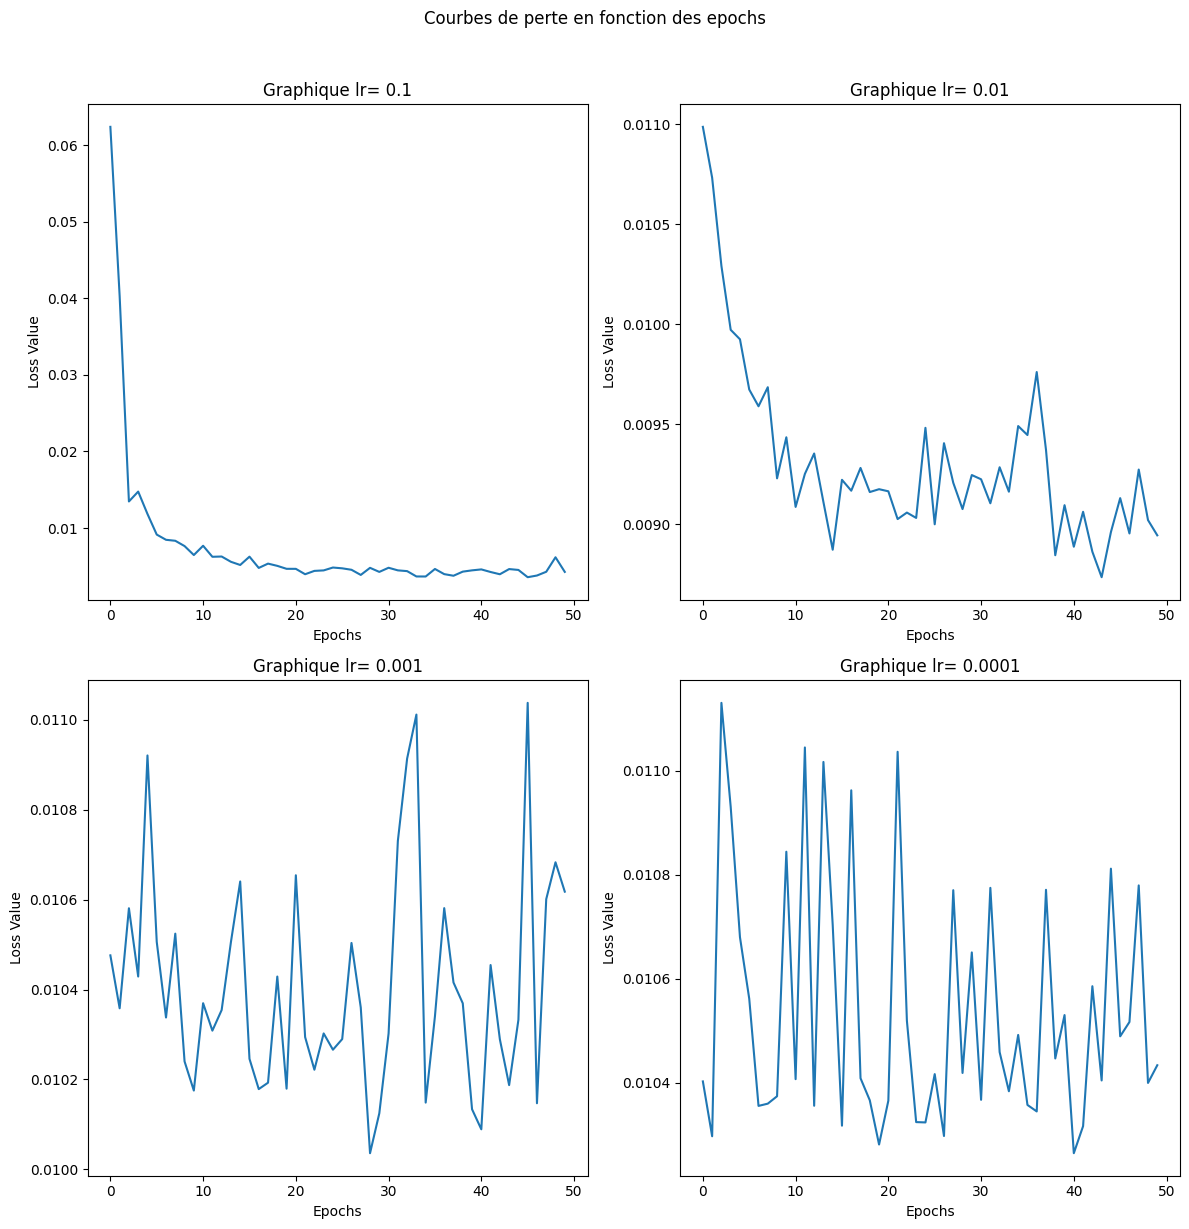

In [20]:
import matplotlib.pyplot as plt

# Création d'une grille pour afficher les graphiques
fig, axes = plt.subplots(2, 2, figsize=(12, 6 * 2))
fig.suptitle('Courbes de perte en fonction des epochs', y=1.02)  # Titre global

# Affichage des courbes dans la grille
for i, loss_saved in enumerate(loss_saveds):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.plot(loss_saved)

    # Ajout de titres aux axes pour chaque sous-plot
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss Value')
    ax.set_title(f'Graphique lr= {list_lr[i]}')

# Ajustement de l'espacement entre les sous-plots
plt.tight_layout()

# Affichage de la grille
plt.show()

### Print de l'accuracy en fonction des epochs

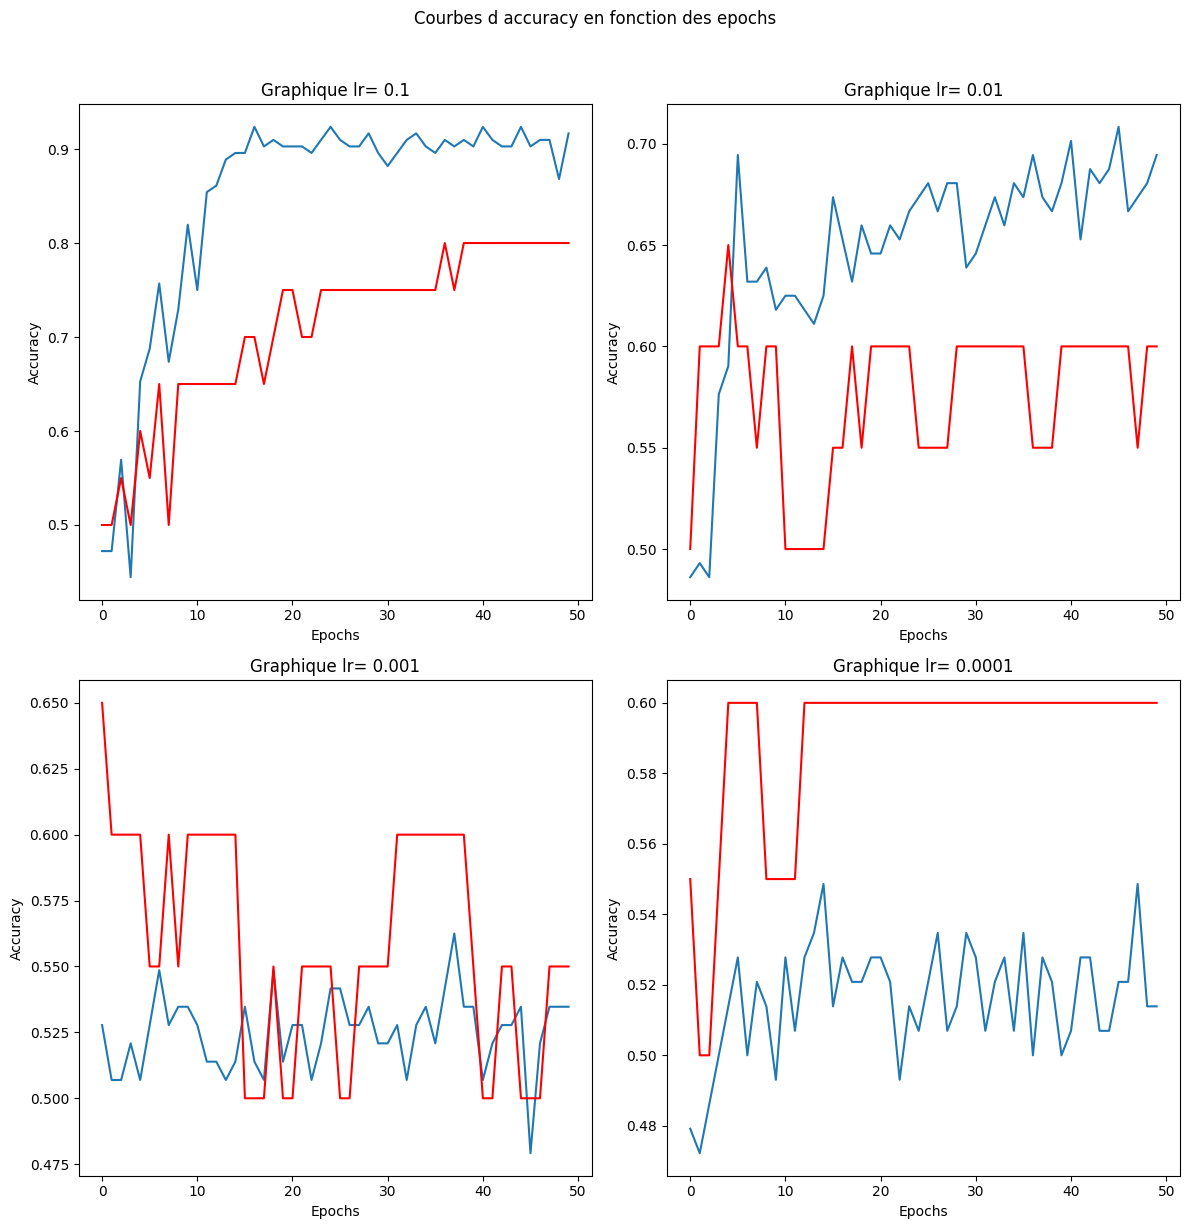

In [21]:
# Création d'une grille pour afficher les graphiques
fig, axes = plt.subplots(2, 2, figsize=(12, 6 * 2))
fig.suptitle('Courbes d accuracy en fonction des epochs', y=1.02)  # Titre global

# Affichage des courbes dans la grille
for i, accuracy_saved in enumerate(accuracy_saveds):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.plot(accuracy_saved,label='train')
    ax.plot(test_accuracy_saveds[i],color='r',label='test')

    # Ajout de titres aux axes pour chaque sous-plot
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Graphique lr= {list_lr[i]}')

# Ajustement de l'espacement entre les sous-plots
plt.tight_layout()

# Affichage de la grille
plt.show()

### Test the network on the test data

#### First test on one frame

torch.Size([3, 576, 576])


<function matplotlib.pyplot.show(close=None, block=None)>

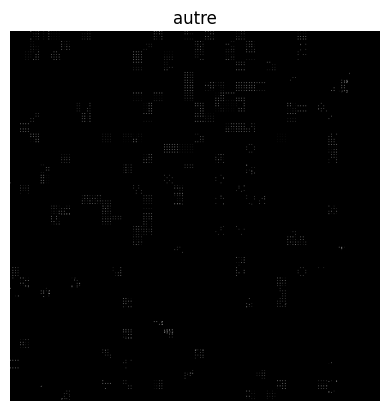

In [22]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

img = images[0].cpu()  # Copie le tensor sur le CPU
label = labels[0].cpu()  # Copie le tensor sur le CPU

print(img.size())

plt.title(labels_map[int(label.numpy())])
plt.axis("off")
plt.imshow(denormalize(img))
plt.show

In [23]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

In [24]:
predicted = predicted.cpu()  # Copie le tensor sur le CPU
print(labels_map[int(predicted[0].numpy())])


youtube


#### Let us look at how the network performs on the whole dataset

#### Result by class

In [25]:
classes = ('youtube','autre')
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)  # Copie les images sur le GPU
        labels = labels.to(device)  # Copie les étiquettes sur le GPU
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: youtube is 60.0 %
Accuracy for class: autre is 60.0 %
